# Q-Learning
In the following two exercises, we will be using Q-Learning to solve two simple reinforcement learning problems. Each exercise has sections with ##TO DO## comments that you will have to change to make the code run.

# N-Armed Bandit Problem
Imagine you are sitting infront of a slot machine with 10 buttons. When you press each button, you get a random reward that is generated from an unknown probability distribution. Each button has a different probability distribution with different means and variances. This means that given enough time, selecting the button with the highest mean will maximize your reward. However, you don't know which button this is. Below, you will implement an $\epsilon$-greedy approach to maximize your reward at this slot machine.
## $\epsilon$ (epsilon)-greedy algorithm
"One very famous approach to solving reinforcement learning problems is the $\epsilon$ (epsilon)-greedy algorithm, such that, with a probability $\epsilon$, you will choose an action a at random (exploration), and the rest of the time (probability 1−$\epsilon$) you will select the best lever based on what you currently know from past plays (exploitation). So most of the time you play greedy, but sometimes you take some risks and choose a random lever and see what happens."

Experiment inspired by https://www.datacamp.com/community/tutorials/introduction-reinforcement-learning#implementation

In [1]:
#import necessary packages
import numpy as np
import random
import matplotlib.pyplot as plt
np.random.seed(5)

In [29]:
#calculate the reward from the choice, mean and variance in the Q_values table
def Reward(choice, buttons_mean, buttons_variance):
    current_reward = np.random.normal(buttons_mean[choice],buttons_variance[choice])
    return current_reward

#Trial creates a new Q table to enact the Policy over "it" number of iterations
def Trial(eps,num_buttons,buttons_mean,buttons_variance,it=1000):
    Q_values = np.zeros(num_buttons) #initialize Q_values table
    Q_tracker = np.zeros(num_buttons) #initialze tracking table
    all_rewards = []
    for i in range(it):
        choice = Policy(eps,num_buttons,Q_values) #make choice
        current_reward = Reward(choice,buttons_mean,buttons_variance) #get reward
        all_rewards.append(current_reward) #store reward
        Q_values,Q_tracker = UpdateQTable(choice,current_reward,Q_values,Q_tracker) #calculate new mean in Q_values table
    return all_rewards #return rewards from the trials

#Experiment now takes a list of epsilons to determine how different choices of greedy epsilons affect convergence of the Policy
def Experiment(eps_list,num_buttons):
    eps_rewards = []
    for eps in eps_list: #iterate over different values of epsilon and run a trial for each
        eps_rewards.append(Trial(eps,num_buttons,buttons_mean,buttons_variance))        
    return eps_rewards #return all rewards for each epsilon value and trial
    

'''TO DO SECTION'''
    
#create an epsilon-greedy policy function that will allow our n-armed bandit to choose which button to press
def Policy(eps,num_buttons,Q_values):
    #initialize a random greedy probability
    greedy_prob =  np.random.rand(1)[0] ###TO DO###
   
    #make a random choice if the greedy_prob is less than eps otherwise take the best choice
    ###TO DO ###
    if greedy_prob<eps:
        choice = np.random.choice(num_buttons, 1)[0]
    else:
        choice = np.argmax(Q_values)
    
    return choice    

#write a function to figure out how to update the Q_values table
#UpdateQTable updates both Q_values with a new current mean and also updates Q_tracker, tracking the number of times
#Q_tracker[choice] has been chosen
#return Q_value, Q_tracker as a tuple
def UpdateQTable(choice,current_reward,Q_values,Q_tracker):
    ###TO DO###
    tracknew = Q_tracker[choice] + 1
    Q_values[choice] = (Q_values[choice]*Q_tracker[choice] + current_reward)/(tracknew)
    Q_tracker[choice] = tracknew
    return Q_values, Q_tracker   

In [30]:
np.random.rand(1)[0]

0.35385196935314145

In [53]:
eps_list = [.01,.05,.15] ###TO DO### choose 3 values of epsilon

num_buttons = 10 #number of buttons or arms our machine has

buttons_mean = [np.random.normal(100,10) for x in range(num_buttons)] #initialize mean of each button
buttons_variance = [np.random.normal(5,2) for x in range(num_buttons)] #initialize variance of each button

# run the experiment
final_exp = Experiment(eps_list, num_buttons) ###TO DO###

#compute running average of reward
for i in range(len(final_exp)):
    for j in range(len(final_exp[0])):
        final_exp[i][j] = np.mean(final_exp[i][:j+1])

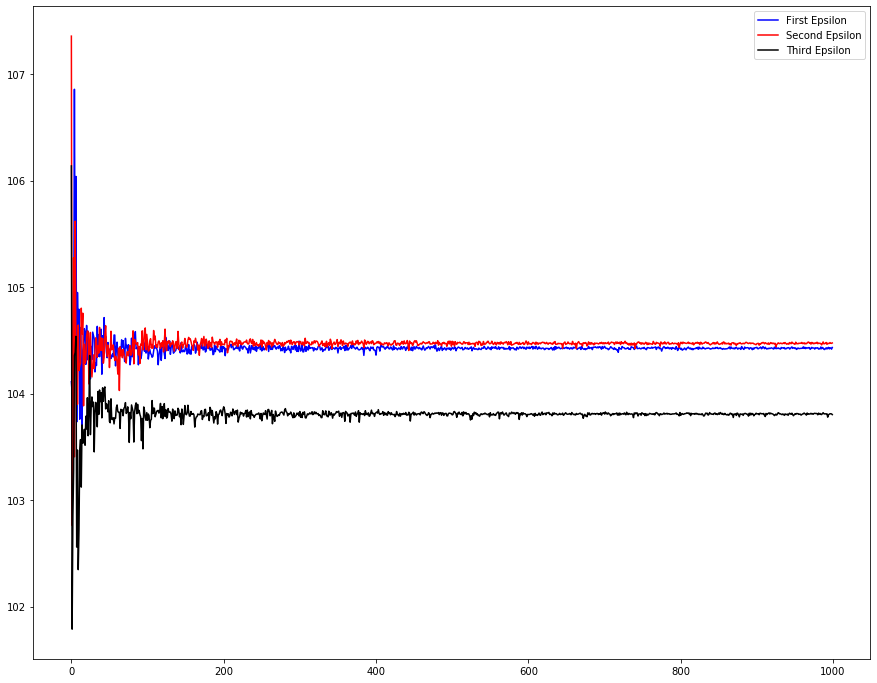

In [54]:
#plot the convergence of the reward's running average for various epsilon values
#if you use more or less than 3 epsilons you will need to change the code below
plt.figure(figsize=(15,12))
plt.plot(final_exp[0],'b',label = 'First Epsilon')#blue
plt.plot(final_exp[1],'r',label = 'Second Epsilon')#red
plt.plot(final_exp[2],'k',label = 'Third Epsilon')#black
plt.legend()
plt.show()

# The self-driving taxi problem
In this exercise, we are going to use Q-Learning to teach a self-driving taxi how to most efficiently pick up and drop off passengers. Imagine that the parking lot pictured below is our environment and the taxi is our agent: 

![alt text](https://storage.googleapis.com/lds-media/images/Reinforcement_Learning_Taxi_Env.width-1200.png "Taxi Example")

In this environment, there are 5 rows and 5 columns that the taxi can move between. Additionally, there are four cells labelled R, G, Y, B that represent the locations passengers can be picked up and dropped off at. Additionally, there are some barriers that the taxi cannot drive through. In the above example, the passenger is located in pickup location Y and would like to be dropped off at location R. 

There are a variety of states that our environment can be in at a given timestep. There are 5 rows the taxi can be located in, 5 columns the taxi can be located in, five locations the passenger can be located (the four locations plus the taxi), and four locations the passenger can be dropped off. This gives the environment a state space of size 500 (5 * 5 * 5 * 4). The action space of the environment is much simpler, with only 6 options:

1. Move south (0)
2. Move north (1)
3. Move east (2)
4. Move west (3)
5. Pickup passenger (4)
6. Dropoff passenger (5)

The 'rules' for the environment are as follows: 
- Every timestep, the agent gets -1 point.
- The agent gets +20 points if it successfully drops off a passenger in the correct location.
- The agent gets -10 points if it tries to pick up a passenger in an incorrect cell.
- The agent gets -10 points if it tries to drop off a passenger at the incorrect cell. 

Using this information, we will use reinforcement Q-learning to teach our agent how to most efficiently pick up and drop off passengers.

You will have to change all of the ##TO DO## comments to make the code run properly.

This exercise borrows some of the code and examples from this [blog post](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/).

First, we will define a classes to help us keep track of the environment:

In [71]:
from collections import namedtuple
State = namedtuple('State', ['row', 'col', 'passenger', 'destination'])
s = State(1,2,3,4)
print(s.col)

2


In [149]:
import numpy as np
from collections import namedtuple

# Will be used to keep track of the environment's state
State = namedtuple('State', ['row', 'col', 'passenger', 'destination'])

# Class to display and update environment state. Keeps track of points and whether or not problem is solved.
class Environment(object):
    
    def __init__(self):
        
        # Initialize a random state
        self.row, self.col, self.passenger, self.destination = self.reset()
        self.state = State(self.row, self.col, self.passenger, self.destination) # Hint: Look at the namedtuple above to see what we want to store in our state.
        
        # Define walls and pickup/dropoff locations
        self.walls = [(0, 1), (3, 0), (4, 0), (3, 2), (4, 2)]
            
        # Dictionary that will map the passenger's state to a location on the map
        self.locs = [(0, 0), (0, 4), (4, 0), (4, 3), (-1, -1)]
        self.loc_dict = dict(zip([0, 1, 2, 3, 4], self.locs))
        
        # Dictionary containing all possible states that will map a state to a row in the Q-table
        self.state_space = self.populate_state_space()

    
    # Some inspiration from: https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py
    def step(self, action):
        
        penalties = 0
        points = -1
        complete = False
        col, row, passenger = self.col, self.row, self.passenger

        if action == 0: # Step south
            row = min(self.row + 1, 4)
            
        elif action == 1: # Step north
            row = max(self.row - 1, 0)
            
        elif action == 2 and (self.row, self.col) not in self.walls: # Step east
            col = min(self.col + 1, 4)
            
        elif action == 3 and (self.row, self.col - 1) not in self.walls: # Step west
            col = max(self.col - 1, 0)
            
        elif action == 4: # Pickup passenger
            if self.passenger != 4 and (self.row, self.col) == self.loc_dict[self.passenger]:
                passenger = 4
            else:
                points += -10
                penalties += 1
                
        elif action == 5: # Dropoff passenger
            
            # If holding the passenger and in the destination, the task is complete.
            if self.passenger == 4 and (self.row, self.col) == self.loc_dict[self.destination]:
                points += 20
                complete = True
            else:
                points += -10
                penalties += 1
        
        # Update location, points and state
        self.row, self.col, self.passenger = row, col, passenger## TO DO ##
        self.points += points
        self.penalties += penalties
        self.complete = complete
        self.state = State(self.row, self.col, self.passenger, self.destination)## TO DO ##
        
        return self.state, points, complete
        
    def populate_state_space(self):
        
        space = []
        
        # Iterate through all possible state spaces to make dictionary that can be used as to create the Q-table
        for row in range(5):    
            for col in range(5):
                for passenger in range(5):
                    for destination in range(4):
                        space.append(State(row=row, col=col, passenger=passenger, destination=destination))
                        
        return dict(zip(space, range(len(space))))
        
    
    # Reset to initial random state
    def reset(self):
        row = np.random.randint(5)
        col = np.random.randint(5)
        # initialize this to 4 instead of 5 so passenger doesn't start in taxi
        passenger = np.random.randint(4)
        destination = np.random.randint(4)
        
        # Make sure passenger and destination aren't the same
        while passenger == destination:
            passenger = np.random.randint(4)
            destination = np.random.randint(4)
        
        self.points = 0
        self.penalties = 0
        self.complete = False
        self.row, self.col, self.passenger, self.destination = row, col, passenger, destination

        return row, col, passenger, destination
    
    # Print out environment
    def display(self, action=None):
        loc_map = {self.loc_dict[self.passenger]: 'P',
                   self.loc_dict[self.destination]: 'D',
                   (self.row, self.col): 'T'}
        
        out = '+---------+\n'
        for row in range(5):
            out += '|'
            for col in range(5):

                if (row, col) in loc_map:
                    out += loc_map[(row, col)]
                else: 
                    out += ' '
                if (row, col) in self.walls or col == 4:
                    out += '|'
                else:
                    out += ':'
            out += '\n'
                
        out += '+---------+\n'
        out += 'Points: {}\n'.format(self.points)
        
        if action is not None:
            
            act_map = {0: 'Moved South',
                       1: 'Moved North',
                       2: 'Moved East',
                       3: 'Moved West',
                       4: 'Picked Up Passenger',
                       5: 'Dropped Off Passenger'}
            
            out += 'Action: {}\n'.format(act_map[action])
            
        return out
    
    def __repr__(self):
        return(self.display())


First, lets see how well we do by choosing random actions:

In [76]:
from IPython.display import clear_output

# Initialize environment
env = Environment()

# Lists to store points
points = []
eps = []
errors = []

for i in range(1, 1001):
    
    frames = []
    epochs = 0
    
    # Repeat while the task is not complete
    while not env.complete:## TO DO ##: Hint: There is an attribute in the environment class that says whether or not the task is complete. 
        
        # Take a random action
        action = np.random.randint(6)
        
        ## TO DO ## Replace with method in class that takes a step for us
        env.step(action)
        frames.append(env.display(action) + 'Epochs: {}\n'.format(epochs))

        epochs += 1
    
    if i % 100 == 0:
        clear_output(wait=True)
        print('{} Epochs completed'.format(i))
    points.append(env.points)
    errors.append(env.penalties)
    eps.append(epochs)
    env.reset()


1000 Epochs completed


+---------+
| : | : :T|
| : : : : |
| : : : : |
| | : | : |
| | : | : |
+---------+
Points: -2499
Action: Dropped Off Passenger
Epochs: 628



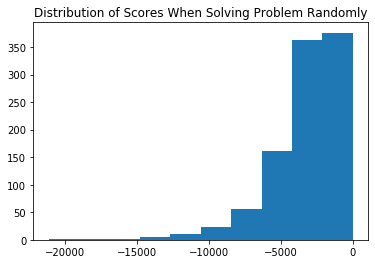

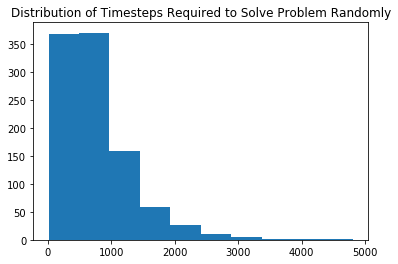

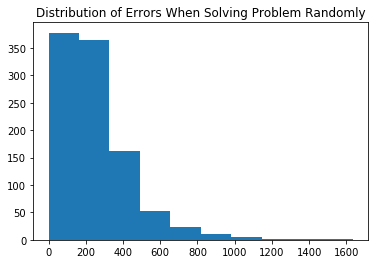

In [78]:
%matplotlib inline
from time import sleep
import matplotlib.pyplot as plt

# print out solution
for frame in frames:
    clear_output(wait=True)
    print(frame)
    sleep(.01)
        
plt.hist(points)
plt.title('Distribution of Scores When Solving Problem Randomly')
plt.show()

plt.hist(eps)
plt.title('Distribution of Timesteps Required to Solve Problem Randomly')
plt.show()

plt.hist(errors)
plt.title('Distribution of Errors When Solving Problem Randomly')
plt.show()

Clearly, selecting actions at random isn't a good way to solve this problem. It can take up to 1000 epochs to find the passenger, pick them up, and drop them off at the correct location. Next, lets try implementing a Q-Learning function to see if it helps speed up the process. First, we will have to learn a Q function that maps state, action pairs to a reward. We can define this Q function as:

$$
Q(s, a) = (1-\alpha)Q(s, a) + \alpha(r + \gamma \max\limits_{a} Q(s', a))
$$

where $a$ is the action we take, $s$ and $s'$ are the current and next state, respectively, r is the reward,  $\alpha$ is the step size, and $\gamma$ is the discount on future rewards. Recall that we also need an $\epsilon$ hyperparameter that defines the probability with which we take a random action. This parameter will ensure that we both explore the entire state space and take actions that maximize reward.

50000 Epochs completed


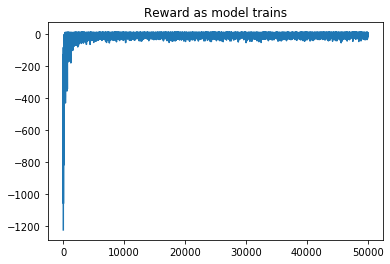

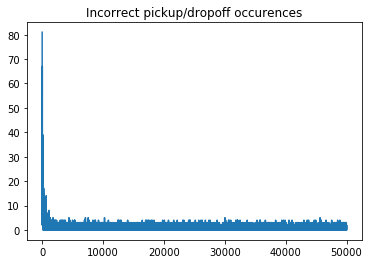

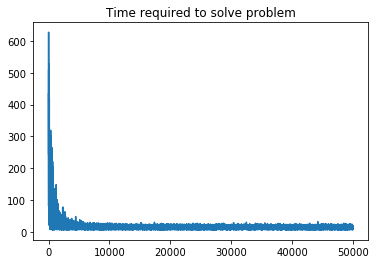

In [124]:
# Create an empty Q-table that is of size (state space by action space)
q_table = np.zeros([500, 6])

env = Environment()

# Map each state to a unique id
state_map = env.state_space

# Hyperparameters
alpha = 0.1
gamma = 0.5
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []
rewards = []

for i in range(1, 50001):
    
    state = env.reset()## TO DO ## Replace with Environment method that resets to a new state
    
    # Will keep track of metrics as model trains
    epochs, penalties, points = 0, 0, 0
    
    while not env.complete:
        
        # Map the action to a location in the Q-table
        state_num = state_map[state]
        
        # Take random action with probability epsilon
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(6)
            
        # Otherwise take the action that maximizes reward
        else:
            action = np.argmax(q_table[state_num,:])## TO DO ## Replace with action that maximizes reward for the current state

        # Determine the state and reward given by the step taken by an action 
        next_state, reward, _ = env.step(action) ## TO DO ## 
        
        # Map the action to a location in the Q-table
        next_num = state_map[next_state]
        
        # Look up the reward in the Q-table for the last time step
        old_value = q_table[state_num, action]## TO DO ##
        
        # Predict the maximum possible reward for the next timestep
        next_max = q_table[next_num, np.argmax(q_table[next_num,:])]## TO DO ##
        
        # Update Q-Table with discounted future reward. This is where we implement the equation given above.
        # In this case, our Q 'function' is the Q-Table
        new_value = (1-alpha)*old_value + alpha*(reward + gamma*next_max)## TO DO ##
        q_table[state_num, action] = new_value
        
        # Reset the old state to the next state
        state = next_state## TO DO ## 
        epochs += 1
    
    rewards.append(env.points)
    all_penalties.append(env.penalties)
    all_epochs.append(epochs)
    
    if i % 100 == 0:
        clear_output(wait=True)
        print('{} Epochs completed'.format(i))

plt.plot(range(50000), rewards)
plt.title('Reward as model trains')
plt.show()

plt.plot(range(50000), all_penalties)
plt.title('Incorrect pickup/dropoff occurences')
plt.show()

plt.plot(range(50000), all_epochs)
plt.title('Time required to solve problem')
plt.show()

In [179]:
x = np.random.random((100, 5))
np.argmax(x[50,:])
print(env.walls)
for i in range(5):
    env.walls[i] = (0,4)
env.walls = [(0, 1), (3, 0), (4, 0), (3, 2), (4, 2)] #To reset the walls
print(env.walls)

[(0, 4), (0, 4), (0, 4), (0, 4), (0, 4)]
[(0, 1), (3, 0), (4, 0), (3, 2), (4, 2)]


In [180]:
points = []
eps = []
errors = []
print(env.walls)
all_frames = []

for _ in range(1000):
    
    state = env.reset()## TODO ## Reinitialize the environment
    epochs, penalties, reward = 0, 0, 0
    
    frames = []
    while not env.complete:
        
        state_num = state_map[state]

        # Always take the action that maximizes reward
        action = np.argmax(q_table[state_num,:])## TO DO ##
            
        state, reward, _ = env.step(action)## TO DO ## Take a step according to the action

        epochs += 1
        frames.append(env.display(action))
        
    all_frames.append(frames)
    
    points.append(env.points)
    errors.append(env.penalties)
    eps.append(epochs)


[(0, 1), (3, 0), (4, 0), (3, 2), (4, 2)]


+---------+
| : | : : |
| : : : : |
| : : : : |
| | : | : |
|T| : | : |
+---------+
Points: 7
Action: Dropped Off Passenger



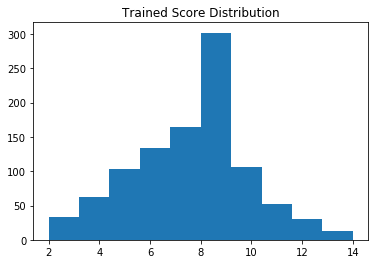

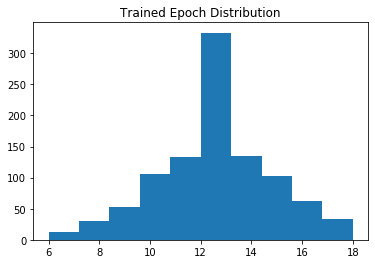

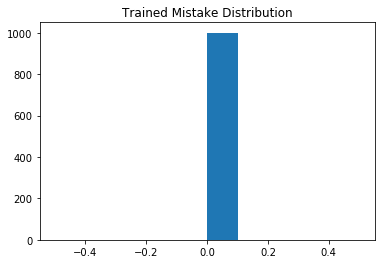

In [181]:
# Print out a solution
for frame in all_frames[-1]:
    clear_output(wait=True)
    print(frame)
    sleep(0.5)

plt.hist(points)
plt.title('Trained Score Distribution')
plt.show()

plt.hist(eps)
plt.title('Trained Epoch Distribution')
plt.show()

plt.hist(errors)
plt.title('Trained Mistake Distribution')
plt.show()

In [182]:
print(env)
print(q_table[state_num])

+---------+
| : | : : |
| : : : : |
| : : : : |
| | : | : |
|T| : | : |
+---------+
Points: 7

[18.  8. 18. 18.  8. 38.]


# Questions: 
1. Why do some indices other than the dropoff index (index 5) in the q_table have high rewards in the final state (printed above)? If we are only getting positive points for dropping off the passenger in this state, shouldn't all other rewards be negative?
2. What specifically are each of the three hyperparameters ($\alpha$, $\gamma$ and $\epsilon$) accomplishing?
3. Is the trained model being as efficient as possible? Is it taking any incorrect steps after training?
4. If you move some of the walls in the environment by changing the env.walls attribute, will the trained agent still be able to accomplish the task? Why or why not?

0: 'Moved South'
1: 'Moved North'
2: 'Moved East'
3: 'Moved West'
4: 'Picked Up Passenger'
5: 'Dropped Off Passenger'

1) The indices that are larger in this case are directions that the car cannot move to. So if the car tries to move in those directions it will remain in the current state with the potential max state still being the dropoff of the passenger. If you move north, the next max state is moving to the cell you are currently in which has a lower reward, and attempting to pick up a passenger loses you a considerable number of points. So in the ranking of best to worst action, attempting to move and staying in the same spot is less costly then moving away or trying to pick someone up who isn't there.

2) $\alpha$ determines the relative importance of your current move and the difference between your reward and the quality of a future state, $\gamma$ determines how important the maximum quality of the next step, and $\epsilon$ determines how frequently you go take a non-greedy action that could potentially cost short term rewards.

3) My model is not taking any incorrect steps after training. Interstingly I ran the model using a purely greedy approach and still converged on the solution. So it is possible that taking risk may not be important in learning to solve this problem. This may indicate that there is a more efficient way to train this algorithm. 

4) The poor little guy couldn't still solve the maze when I changed a wall, but could still solve it if a walls are moved to the edge of the domain. My guess is that if a barrier is added within the domain it added enough complexity to prevent the agent from completing the task, but removing compexity from the task did not affect its ability to solve the task. 